# Getting Your Data From Yelp!

In order to make sure you are on track to completing the project, you will complete this workbook first. Below are steps that you need to take in order to make sure you have your data from yelp and are ready to analyze it. Your cohort lead will review this workbook with you the Wednesday before your project is due.    

## Part 1 - Understanding your data and question

You will be pulling data from the Yelp API to complete your analysis. The api, however, provides you with a lot of information that will not be pertinent to your analysis. YOu will pull data from the api and parse through it to keep only the data that you will need. In order to help you identify that information,look at the API documentation and understand what data the api will provide you. 

Identify which data fields you will want to keep for your analysis. 

https://www.yelp.com/developers/documentation/v3/get_started

In [73]:
import json
import requests
import data
import sys
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
!pip3 install folium

In [2]:
print(sys.path)

['/Users/leratsayukova/Documents/Flatiron/Bikes_Repo', '/Users/leratsayukova/opt/anaconda3/lib/python38.zip', '/Users/leratsayukova/opt/anaconda3/lib/python3.8', '/Users/leratsayukova/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/leratsayukova/opt/anaconda3/lib/python3.8/site-packages', '/Users/leratsayukova/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/leratsayukova/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/leratsayukova/.ipython']


In [3]:
url= 'https://api.yelp.com/v3/businesses/search'

In [4]:
client_id = 'UPd8KVfQybexrmKSjNF-mA'
api_key = 'TQ3V7mYVhRo1vOV7HFkQEuG-QKC7eVgNjpOkfkGD43EnLnLLY2ub-owG779hx-vZI6YX6YQZSxmE9kOjoo8iQYMx3mq0pwqenQ3Jc_vYjMZCci2PPC-BevZVmZomYHYx'


___

## Part 2 - Create ETL pipeline for the business data from the API

Now that you know what data you need from the API, you want to write code that will execute a api call, parse those results and then insert the results into the DB.  

It is helpful to break this up into three different functions (*api call, parse results, and insert into DB*) and then you can write a function/script that pull the other three functions together. 

Let's first do this for the Business endpoint.

- Write a function to make a call to the yelp API

In [5]:
headers = {'Authorization':'Bearer {}'.format(api_key),}
 

In [6]:

term= 'Bike Shop'
location='Austin'
categories='Bikes'

In [7]:
url_params = {
                "term": term.replace(' ', '+'),
                "location": location.replace(' ', '+'),
                "categories" : categories,
                "limit": 50,
    
            }

In [8]:
def yelp_call(url_params, api_key):
    
    response= requests.get(url, headers=headers, params=url_params)  
    
    if response.status_code==200:
        return response.json()
     
    else: 
        return response.status_code
    


In [9]:
response= yelp_call(url_params, api_key)

## can we make a loop for the function to call itself ?

In [10]:
business_data= response['businesses']

In [11]:
response['total']

140

In [12]:
business_data[0]

{'id': 'wfKxBxJ8RFZj8jOB6Lpn-Q',
 'alias': 'bicycle-sport-shop-austin-2',
 'name': 'Trek Bicycle Lamar',
 'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/d3F2l_l2O-idm3TMUMgWNQ/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/bicycle-sport-shop-austin-2?adjust_creative=UPd8KVfQybexrmKSjNF-mA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=UPd8KVfQybexrmKSjNF-mA',
 'review_count': 280,
 'categories': [{'alias': 'bikes', 'title': 'Bikes'},
  {'alias': 'bikerentals', 'title': 'Bike Rentals'},
  {'alias': 'bike_repair_maintenance', 'title': 'Bike Repair/Maintenance'}],
 'rating': 4.5,
 'coordinates': {'latitude': 30.259626, 'longitude': -97.75817},
 'transactions': [],
 'price': '$$',
 'location': {'address1': '517 S Lamar Blvd',
  'address2': '',
  'address3': '',
  'city': 'Austin',
  'zip_code': '78704',
  'country': 'US',
  'state': 'TX',
  'display_address': ['517 S Lamar Blvd', 'Austin, TX 78704']},
 'phone': '+15124773472',
 'display_phone':

**What data do we want from each business?**

- Write a function to parse the API response so that you can easily insert the data in to the DB

In [14]:
def parse_results(results):
    parsed_results =[]
    for biz in results:
        biz_info= ( biz['id'],
                   biz['name'],
                   biz['rating'],
                   biz['review_count'],
                   biz['location']['zip_code'])
        parsed_results.append(biz_info)
    
    return parsed_results



In [16]:
parsed_results= parse_results(business_data)
parsed_results

[('wfKxBxJ8RFZj8jOB6Lpn-Q', 'Trek Bicycle Lamar', 4.5, 280, '78704'),
 ('WT_d47o-V5xlMNx8trI0-A', 'Monkey Wrench Bicycles', 5.0, 94, '78751'),
 ('oTujfSf88bPOcUWEmDBzjQ', 'The Peddler Bike Shop', 4.5, 176, '78751'),
 ('1yvLoRRt15RraRMlrdUBTg', 'Cycleast', 5.0, 67, '78702'),
 ('KVPUN4yU-2juc8Pc4sxKVQ', 'Clown Dog Bikes', 5.0, 134, '78705'),
 ('-Cza7JtBZZ7nuXZeStwPAA', 'Bike Farm', 4.5, 104, '78756'),
 ('4EdSNL5cShH-ZNsUbwWSJQ', 'Trek Bicycle Research', 4.5, 93, '78759'),
 ('ZtuzXaoMnY1gd0kMZFdpcw', "Mellow Johnny's Bike Shop", 4.0, 205, '78701'),
 ('lXodVpk5ZUOVymDBlb10Zg', 'Trek Bicycle Guadalupe', 4.5, 10, '78705'),
 ('2lIEXCMqbUaYJ98_cwAd2A', 'East Side Pedal Pushers', 4.5, 127, '78702'),
 ('xxFBa5ZuMb0S92wxYeAOcQ', 'Trek Bicycle Bee Cave', 4.0, 13, '78733'),
 ('-4SfHHiTVTLeOEt8TF0nTQ', 'Bikealot', 4.5, 30, '78745'),
 ('gWhCMZVm0ITZC7KxI3M2Pw', 'Texas Cycle Werks', 4.5, 37, '78735'),
 ('18UGjpTexL3nRJ4UrMSM7w', 'Trek Bicycle Parmer', 4.0, 71, '78717'),
 ('JN_AiBjGmF4dDdJIYKT7SA', 'Cy

- Write a function to take your parsed data and add it to the csv file where you will store all of your results. 

In [19]:
def df_save(csv_filepath, parsed_results):
    
    
    pr_df= pd.DataFrame(parsed_results, columns= 
             ['id','name', 'rating', 'review_count', 'zipcode'])
    
    pr_csv=pr_df.to_csv(path_or_buf=csv_filepath, mode="a", header="False")
   
    return print("Results added!")
   

- Write a script that combines the three functions above into a single process.

While it will take some experimentation to write the functions above, once you get them working it will be best to put them in a `.py` file and then import the functions to use in a script 

In [22]:
def yelp_data(url_params, api_key):
    yelp_call(url_params, api_key)
    parse_results(business_data)
    df_save('/Users/leratsayukova/Documents/Flatiron/Bikes_Repo/data/bikes_data', parsed_results)
    our_data= pd.read_csv('/Users/leratsayukova/Documents/Flatiron/Bikes_Repo/data/bikes_data')
    return our_data

In [23]:
yelp_data(url_params,api_key)

Results added!


,Unnamed: 0,id,name,rating,review_count,zipcode
0,0,wfKxBxJ8RFZj8jOB6Lpn-Q,Trek Bicycle Lamar,4.5,280,78704
1,1,WT_d47o-V5xlMNx8trI0-A,Monkey Wrench Bicycles,5.0,94,78751
2,2,oTujfSf88bPOcUWEmDBzjQ,The Peddler Bike Shop,4.5,176,78751
3,3,1yvLoRRt15RraRMlrdUBTg,Cycleast,5.0,67,78702
4,4,KVPUN4yU-2juc8Pc4sxKVQ,Clown Dog Bikes,5.0,134,78705
5,5,-Cza7JtBZZ7nuXZeStwPAA,Bike Farm,4.5,104,78756
6,6,4EdSNL5cShH-ZNsUbwWSJQ,Trek Bicycle Research,4.5,93,78759
7,7,ZtuzXaoMnY1gd0kMZFdpcw,Mellow Johnny's Bike Shop,4.0,205,78701
8,8,lXodVpk5ZUOVymDBlb10Zg,Trek Bicycle Guadalupe,4.5,10,78705
9,9,2lIEXCMqbUaYJ98_cwAd2A,East Side Pedal Pushers,4.5,127,78702


In [24]:
# create a variable  to keep track of which result you are in. 
cur = 0
num= response['total']

#set up a while loop to go through and grab the result 
while cur <= num and cur < 1000:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = cur
    #make your API call with the new offset number
    results =  yelp_call(url_params, api_key)
    
    #after you get your results you can now use your function to parse those results
    new_parsed_results = parse_results(results['businesses'])
    
    # use your function to insert your parsed results into the db
    df_save('/Users/leratsayukova/Documents/Flatiron/Bikes_Repo/data/bikes_data', new_parsed_results)
    
    
    #increment the counter by 50 to move on to the next results
    cur += 50

Results added!
Results added!
Results added!


In [26]:
bikes_csv= pd.read_csv('/Users/leratsayukova/Documents/Flatiron/Bikes_Repo/data/bikes_data', header=0, 
                       names=['business_id','biz_name', 'biz_rating', 'biz_review_count', 'biz_zipcode']).reset_index(drop=True)
# pd.set_option('display.max_rows', None, 'display.max_columns', None)
bikes_csv

,business_id,biz_name,biz_rating,biz_review_count,biz_zipcode
0,wfKxBxJ8RFZj8jOB6Lpn-Q,Trek Bicycle Lamar,4.5,280,78704
1,WT_d47o-V5xlMNx8trI0-A,Monkey Wrench Bicycles,5.0,94,78751
2,oTujfSf88bPOcUWEmDBzjQ,The Peddler Bike Shop,4.5,176,78751
3,1yvLoRRt15RraRMlrdUBTg,Cycleast,5.0,67,78702
4,KVPUN4yU-2juc8Pc4sxKVQ,Clown Dog Bikes,5.0,134,78705
...,...,...,...,...,...
184,Y5RaFaBi8rsL2NAkne17gQ,Autocycle Icehouse,3.0,5,78612
185,-Ijgv6vbojWToDadfgTrDw,Cycle Gear,3.5,73,78758
186,jBrs3faqdh87bDVy8Mc0KQ,Powersports Superstore,1.5,71,78613
187,y5BOiP6w31yZosdcSHd1BQ,Crossroad Bikes,5.0,18,78231


In [27]:
Bikes_csv= bikes_csv.drop([50,101])
Bikes_csv


,business_id,biz_name,biz_rating,biz_review_count,biz_zipcode
0,wfKxBxJ8RFZj8jOB6Lpn-Q,Trek Bicycle Lamar,4.5,280,78704
1,WT_d47o-V5xlMNx8trI0-A,Monkey Wrench Bicycles,5.0,94,78751
2,oTujfSf88bPOcUWEmDBzjQ,The Peddler Bike Shop,4.5,176,78751
3,1yvLoRRt15RraRMlrdUBTg,Cycleast,5.0,67,78702
4,KVPUN4yU-2juc8Pc4sxKVQ,Clown Dog Bikes,5.0,134,78705
...,...,...,...,...,...
184,Y5RaFaBi8rsL2NAkne17gQ,Autocycle Icehouse,3.0,5,78612
185,-Ijgv6vbojWToDadfgTrDw,Cycle Gear,3.5,73,78758
186,jBrs3faqdh87bDVy8Mc0KQ,Powersports Superstore,1.5,71,78613
187,y5BOiP6w31yZosdcSHd1BQ,Crossroad Bikes,5.0,18,78231


In [29]:
biz_ids=Bikes_csv.loc[:,'business_id'].to_list()
biz_ids_lst=list(set(biz_ids))


___

## Part 3 -  Create ETL pipeline for the restaurant review data from the API

You've done this for the Businesses, now you need to do this for reviews. You will follow the same process, but your functions will be specific to reviews. Above you have a model of the functions you will need to write, and how to pull them together in one script. For this part, you have the process below 

- In order to pull the reviews, you will need the business ids. So your first step will be to get all of the business ids from your businesses csv. 

- Write a function that takes a business id and makes a call to the API for reivews


- Write a function to parse out the relevant information from the reviews

- Write a function to save the parse data into a csv file containing all of the reviews. 

- Combine the functions above into a single script  

In [33]:
# for loop to get rid of any 'id' in business id list
for idx, bid in enumerate(biz_ids_lst):
    if bid == 'id':
        biz_ids_lst.pop(idx)

In [36]:
def yelp_call_reviews(url_review, api_key):
    response= requests.get(url_reviews, headers=headers)  
    if response.status_code==200:
        return response.json()
    else: 
        return response.status_code


In [37]:
for bid in biz_ids_lst:
    url_reviews='https://api.yelp.com/v3/businesses/' + bid + '/reviews'
    url_data = yelp_call_reviews(url_reviews, api_key)

In [38]:
url_data = yelp_call_reviews(url_reviews, api_key)

In [39]:
review_data= yelp_call_reviews(url_data, api_key)
reviews= review_data['reviews']


In [42]:
def yelp_reviews(url_params_reviews, api_key):
    yelp_call_reviews(biz_ids_lst, api_key)
    parse_reviews(reviews)
    df_save_reviews('/Users/leratsayukova/Documents/Flatiron/Bikes_Repo/data/bikes_reviews', parsed_reviews)
    our_data= pd.read_csv('/Users/leratsayukova/Documents/Flatiron/Bikes_Repo/data/bikes_reviews')
    return our_data

In [44]:
def parse_reviews(bid, reviews):
    parsed_reviews =[]
    for review in reviews:
        review_info= ( bid,
                    review['id'],
                    review['text'],
                    review['rating'] 
                           )
        parsed_reviews.append(review_info)
        
    return parsed_reviews


In [45]:
def df_save_reviews(csv_filepath, parsed_reviews):
    
    
    pr_df= pd.DataFrame(parsed_reviews, columns= 
             ['business_id','id','text', 'rating'])
    
    pr_csv=pr_df.to_csv(path_or_buf=csv_filepath, mode="a", header=False)
   
    return print("Results added!")
            

In [46]:
for bid in biz_ids_lst:
# #     print(bid)
    url_reviews='https://api.yelp.com/v3/businesses/' + bid + '/reviews'
    url_data = yelp_call_reviews(url_reviews, api_key)
    new_reviews = yelp_call_reviews(bid, api_key)
    #after you get your results you can now use your function to parse those results
    new_parsed_reviews = parse_reviews(bid,new_reviews['reviews'])
     # use your function to insert your parsed results into the db
    df_save_reviews('/Users/leratsayukova/Documents/Flatiron/Bikes_Repo/data/bikes_reviews', new_parsed_reviews)
   


Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results added!
Results ad

In [47]:
parsed_reviews= parse_reviews(bid, reviews)

In [49]:
Reviews_csv= pd.read_csv('/Users/leratsayukova/Documents/Flatiron/Bikes_Repo/data/bikes_reviews', 
            names=['business_id', 'review_id', 'text', 'rating']).reset_index(drop=True)

## Part 4 -  Using python and pandas, write code to answer the questions below. 


- Which are the 5 most reviewed businesses in your dataset?
- What is the highest rating recieved in your data set and how many businesses have that rating?
- What percentage of businesses have a rating greater than or  4.5?
- What percentage of businesses have a rating less than 3?
- What percentage of your businesseshave a price label of one dollar sign? Two dollar signs? Three dollar signs? No dollar signs?
- Return the text of the reviews for the most reviewed business. 
- Find the highest rated business and return text of the most recent review. If multiple business have the same rating, select the business with the most reviews. 
- Find the lowest rated business and return text of the most recent review.  If multiple business have the same rating, select the business with the least reviews. 


___

**MERGING our DataFrames together on Business Id column**

In [51]:
bk=pd.merge(left=Bikes_csv, right=Reviews_csv, left_on='business_id', right_on='business_id')
bk

,business_id,biz_name,biz_rating,biz_review_count,biz_zipcode,review_id,text,rating
0,wfKxBxJ8RFZj8jOB6Lpn-Q,Trek Bicycle Lamar,4.5,280,78704,NuiFs3SLxy9wiOp4wQSByg,We took one of our bicycles for a brake repair...,5
1,wfKxBxJ8RFZj8jOB6Lpn-Q,Trek Bicycle Lamar,4.5,280,78704,Wdlvy0_mm0dwex4vNMtiCg,"I recently purchased a new Trek from BSS, as w...",5
2,wfKxBxJ8RFZj8jOB6Lpn-Q,Trek Bicycle Lamar,4.5,280,78704,eNix1GULNmi0DlDGsELVGQ,We are from San Antonio and made the drive up ...,5
3,wfKxBxJ8RFZj8jOB6Lpn-Q,Trek Bicycle Lamar,4.5,280,78704,NuiFs3SLxy9wiOp4wQSByg,We took one of our bicycles for a brake repair...,5
4,wfKxBxJ8RFZj8jOB6Lpn-Q,Trek Bicycle Lamar,4.5,280,78704,Wdlvy0_mm0dwex4vNMtiCg,"I recently purchased a new Trek from BSS, as w...",5
...,...,...,...,...,...,...,...,...
534,y5BOiP6w31yZosdcSHd1BQ,Crossroad Bikes,5.0,18,78231,yMghLSRhiaavB3witZG50w,"These guys are honest, straightforward, and do...",5
535,y5BOiP6w31yZosdcSHd1BQ,Crossroad Bikes,5.0,18,78231,jCVHVc3nYdppIMwF-shLug,I cannot say enough good things about these gu...,5
536,CvOv3pBzvVL0dmp6bHicJQ,Black Widow Powersports,4.5,9,78238,AKay0bBDGf-mL6oyQt2CnQ,To start off I've never left a review for a co...,1
537,CvOv3pBzvVL0dmp6bHicJQ,Black Widow Powersports,4.5,9,78238,Yrj8FP1YtbcCwdUWgTAHlg,This dude deserves a 5 star rating cause he do...,5


In [52]:
# Double Checking for Nan Values
bk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539 entries, 0 to 538
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   business_id       539 non-null    object
 1   biz_name          539 non-null    object
 2   biz_rating        539 non-null    object
 3   biz_review_count  539 non-null    object
 4   biz_zipcode       539 non-null    object
 5   review_id         539 non-null    object
 6   text              539 non-null    object
 7   rating            539 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 37.9+ KB


In [53]:
# Check Merged DataFrame for dtypes of columns, we need some columns as integers
bk.dtypes

business_id         object
biz_name            object
biz_rating          object
biz_review_count    object
biz_zipcode         object
review_id           object
text                object
rating               int64
dtype: object

In [54]:
# Converts all the appropriate columns in our dataFrame to numeric types
# so that we can work with values
# Not Zipcode, we have plans for that later
bk[['biz_rating', 'biz_review_count', 'rating']]=bk[[
    'biz_rating', 'biz_review_count', 'rating']].apply(pd.to_numeric)


In [58]:
# Getting a count of the business names in our dataset
bk['biz_name'].describe()

count                           539
unique                          125
top       Academy Sports + Outdoors
freq                             21
Name: biz_name, dtype: object

In [60]:
# Drops all the rows that sell power bikes and NOT peddle bikes
searchfor = ['moto', 'auto', 'power', 'Moto', 'Auto', 'Power', 'Choppers', 'Ducati', 'Harley']
bk = bk[~bk.biz_name.str.contains('|'.join(searchfor))]
# Checks to see if they are dropped
bk['biz_name'].describe()


count                           428
unique                           86
top       Academy Sports + Outdoors
freq                             21
Name: biz_name, dtype: object

In [62]:
# Get total number of zipcodes 
zip_lst=(bk['biz_zipcode'].unique()).tolist()
len(zip_lst)

37

In [63]:
ratings_comp= bk.groupby(['biz_rating']).biz_rating.agg([len])
ratings_comp

,len
biz_rating,
1.0,4.0
2.0,15.0
2.5,9.0
3.0,32.0
3.5,23.0
4.0,60.0
4.5,134.0
5.0,151.0


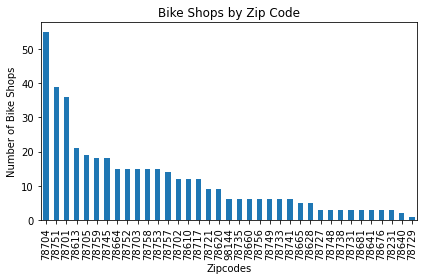

In [76]:
ax= bk['biz_zipcode'].value_counts().plot.bar(x='Zipcodes', y='Number of Pizza shops')



ax.set_title('Bike Shops by Zip Code')
ax.set_xlabel('Zipcodes')
ax.set_ylabel('Number of Bike Shops')
plt.tight_layout()
plt.savefig('Bike Shops by Zip Code')


In [65]:
biz_zipcodes= pd.DataFrame(bk.groupby('biz_zipcode')['biz_rating'].mean())

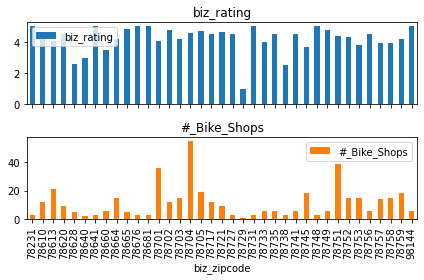

In [75]:
biz_zipcodes['#_Bike_Shops']= bk['biz_zipcode'].value_counts()
biz_zipcodes.sort_values(by=['#_Bike_Shops'])
axes = biz_zipcodes.plot.bar(rot=90, subplots=True)
plt.tight_layout()
plt.savefig('comparing.png')

# Conclusions

#### --The market for bike shops in Austin is already fairly saturated with bike shops
#### --Among exisiting bike stores, ratings are fairly solid.
#### --There is not much need for bike shops in Austin at the present time.